In [245]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
torch.manual_seed(125)

In [246]:
def sin(x):
    if isinstance(x, torch.Tensor):
        return torch.sin(x)
    else:
        return np.sin(x)

def cos(x):
    if isinstance(x, torch.Tensor):
        return torch.cos(x)
    else:
        return np.cos(x)

## Generate training data

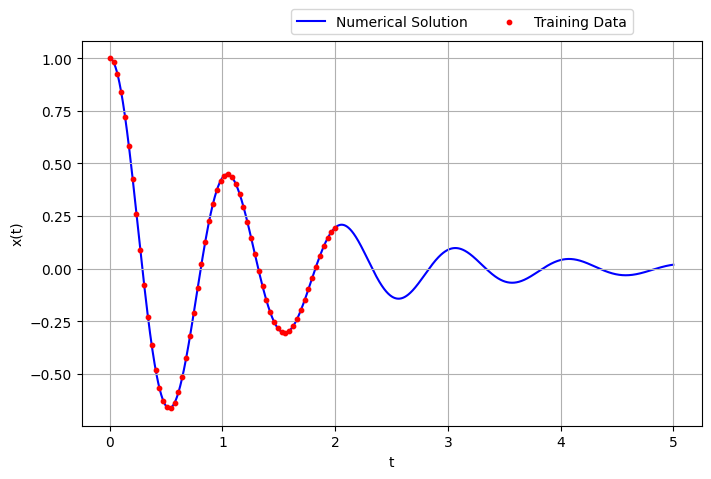

In [247]:
# Parameters and initial conditions
X0 = [1, 0]
w0 = np.pi*2*1
b  = 1.5

# time domain
ti = 0
tf = 5
N  = 10_000

t = torch.linspace(ti, tf, N).view(-1,1)

def F(u, v, t, params):
    w0, b = params
    return -(w0**2)*sin(u) - b*v

def E(u, v, t):
    return 0*u

E0 = E(X0[0], X0[1], ti)

# Numerical Solution

true_params = (w0, b)

def ODE(X, t):
    dXdt = [X[1], F(X[0], X[1], t, true_params)]
    return dXdt

solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 60
t_data     = torch.linspace(ti, tf*0.4, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data       = training_data[:,0].view(-1,1)
x2_data       = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 200
t_val        = torch.linspace(ti*1.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val          = validation_data[:,0].view(-1,1)
x2_val          = validation_data[:,1].view(-1,1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, x1, label='Numerical Solution', color='blue', zorder=1)
ax.scatter(t_data, x1_data, color='red', label='Training Data', s=10, zorder=3)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
plt.legend(ncol=3, bbox_to_anchor=(0.9, 1.1))
plt.grid()
plt.show()

## PINN

In [248]:
def plot_result():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    axes[0].grid()
    axes[0].plot(t, x1, color="gray", linewidth=2, alpha=1,linestyle='--',label="Exact solution", zorder=0)
    axes[0].plot(t, p, color="blue", linewidth=2, alpha=0.8, label="PINN prediction", zorder=1)
    axes[0].scatter(t_data, x1_data, s=15, color="red", alpha=0.4, label='Training data', zorder=2)
    axes[0].scatter(t_physics.detach(), -0*torch.ones_like(t_physics.detach()), s=10, color="green", alpha=0.4,label='Collocation points', zorder=2)
    axes[0].set_ylim(-1.05*x1_max, 1.05*x1_max)
    axes[0].set_ylabel('x(t)',fontsize="x-large")
    axes[0].set_xlabel('t',fontsize="x-large")
    axes[0].legend()
    
    axes[1].grid()
    axes[1].plot(training_loss_history, label='Training Loss', color='red', linewidth=2, zorder=1)
    axes[1].plot(validation_loss_history, label='Validation Loss', color='blue', linewidth=1.5, zorder=2, alpha=0.6)
    axes[1].plot(error_history, label='MSE', color='green', linewidth=2, zorder=3, alpha=0.5)
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, epochs)
    axes[1].set_ylim(1e-7, 1e2)
    axes[1].set_xlabel('Epochs', fontsize="x-large")
    axes[1].set_ylabel('Loss', fontsize="x-large")
    axes[1].set_title(f'MSE = {error:.3e}', fontsize="x-large")
    axes[1].legend()
    
    fig.suptitle(f"Epoch {i}", fontsize="x-large")

    plt.tight_layout()
    plt.axis("on")

In [249]:
# Define Neural Network Structure

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.scale = lambda t: (t - ti)/(tf - ti)
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [250]:
learning_rate = 1e-3
gamma         = 1
epochs        = 50_000 + 1
w_data        = 1e4
w_derivative  = 0e0
w_ode         = 1e0
w_energy      = 0
N_phys        = 50

N_layers = 3
N_nodes  = 32

In [251]:
# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

# Define the sample locations for the ODE loss
t_physics    = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)

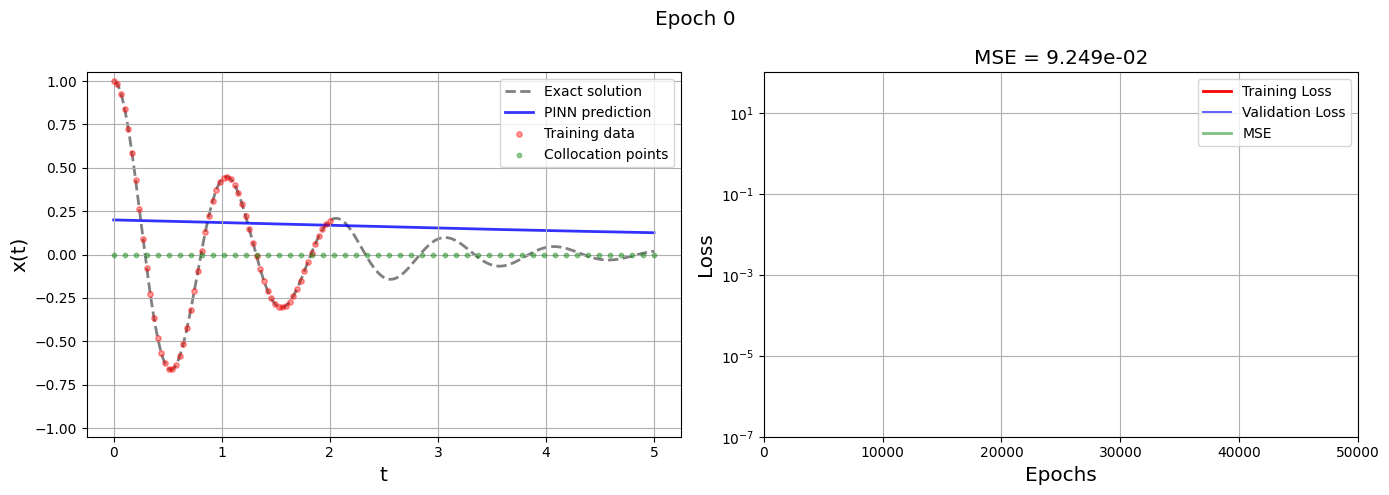

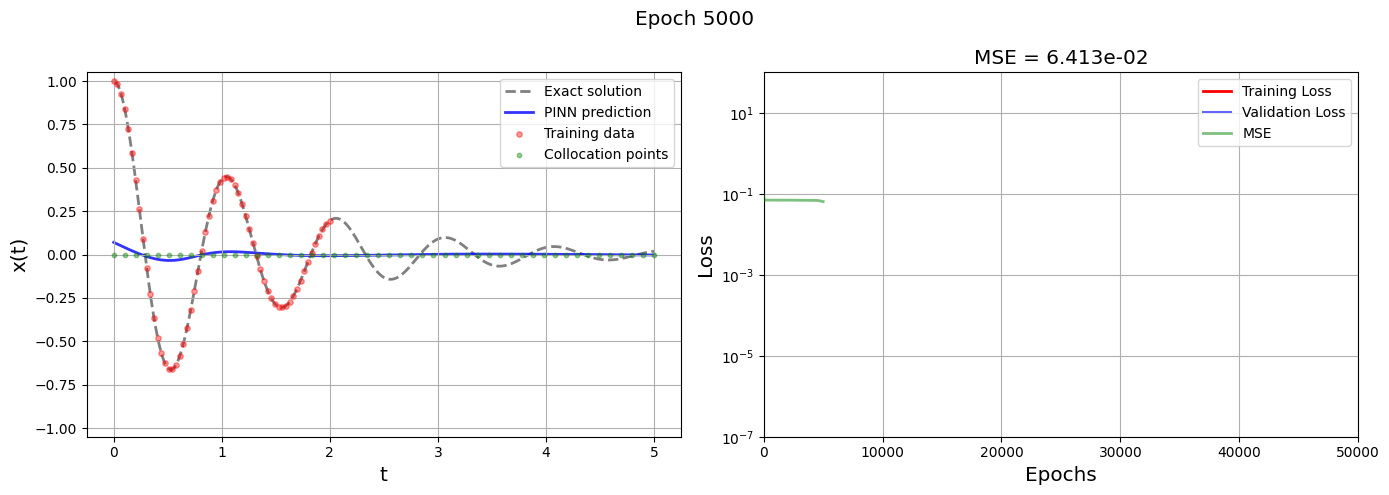

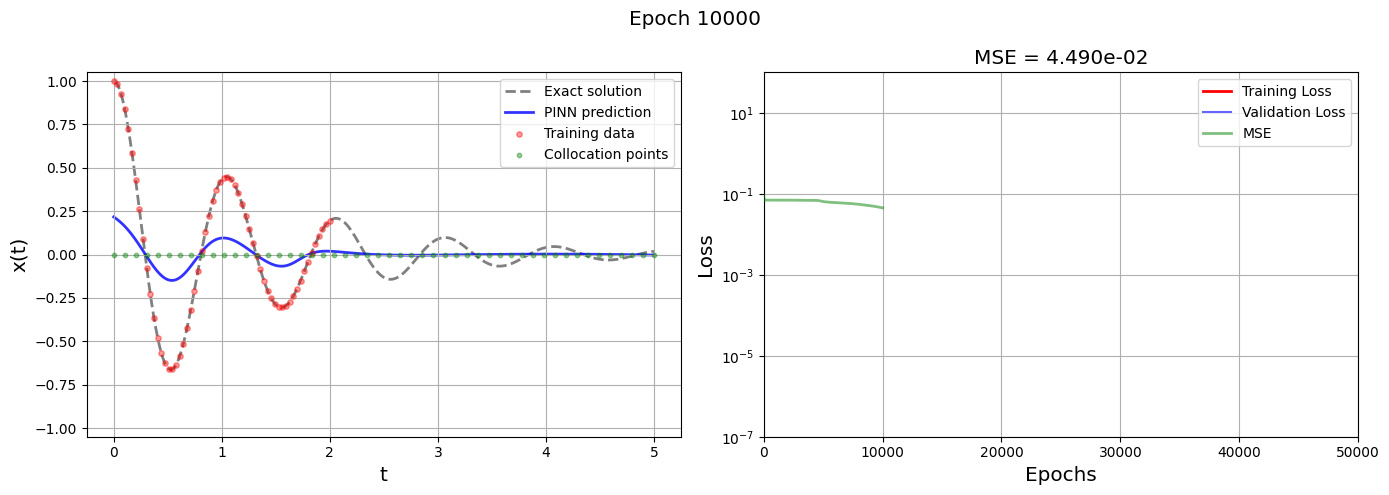

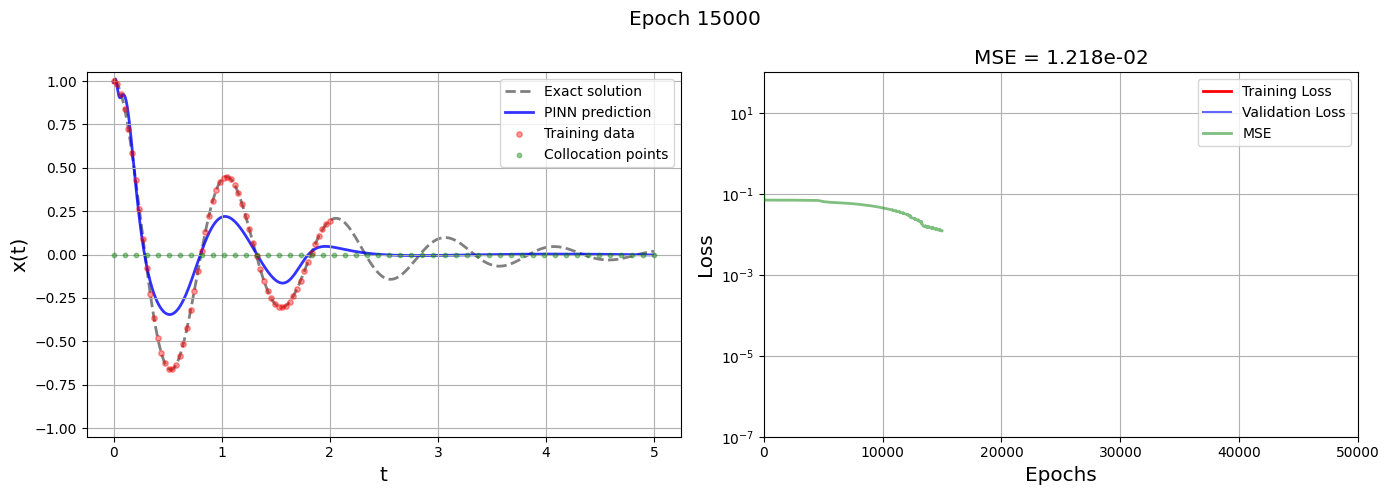

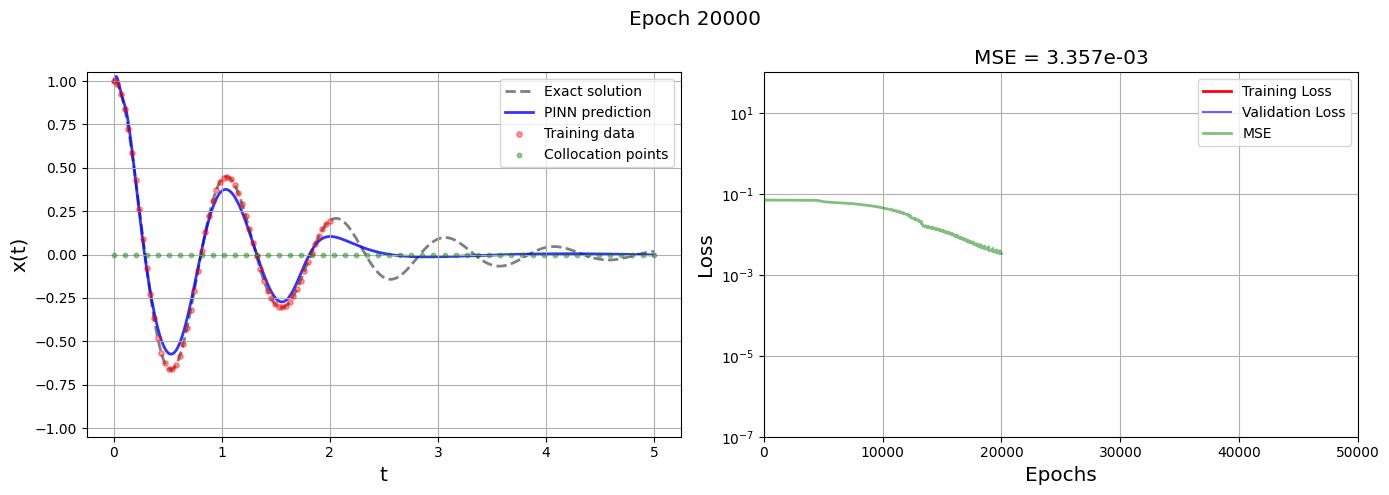

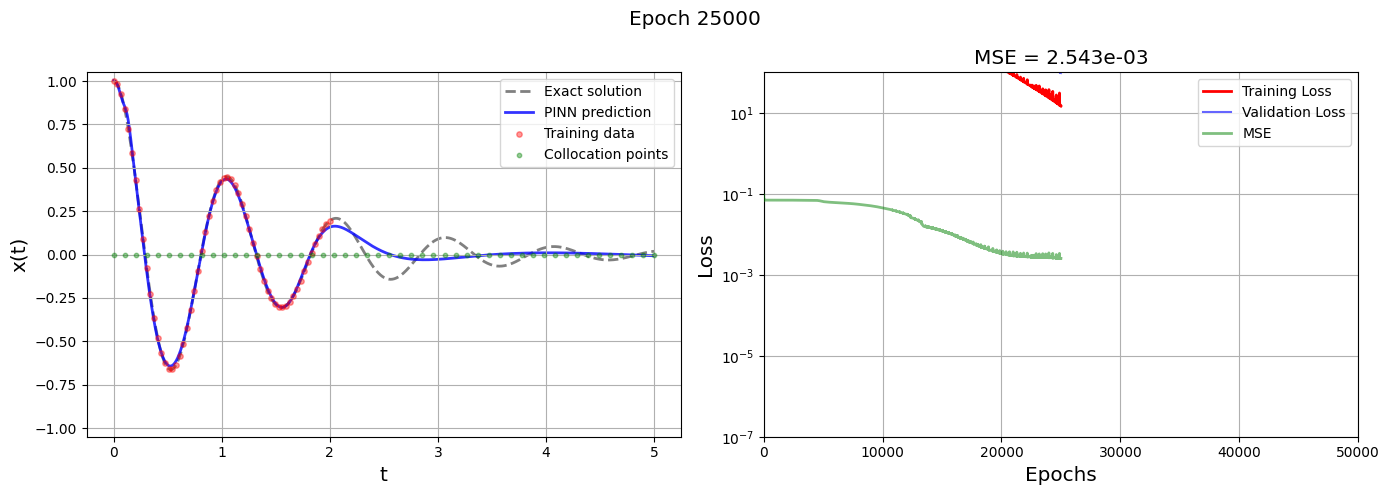

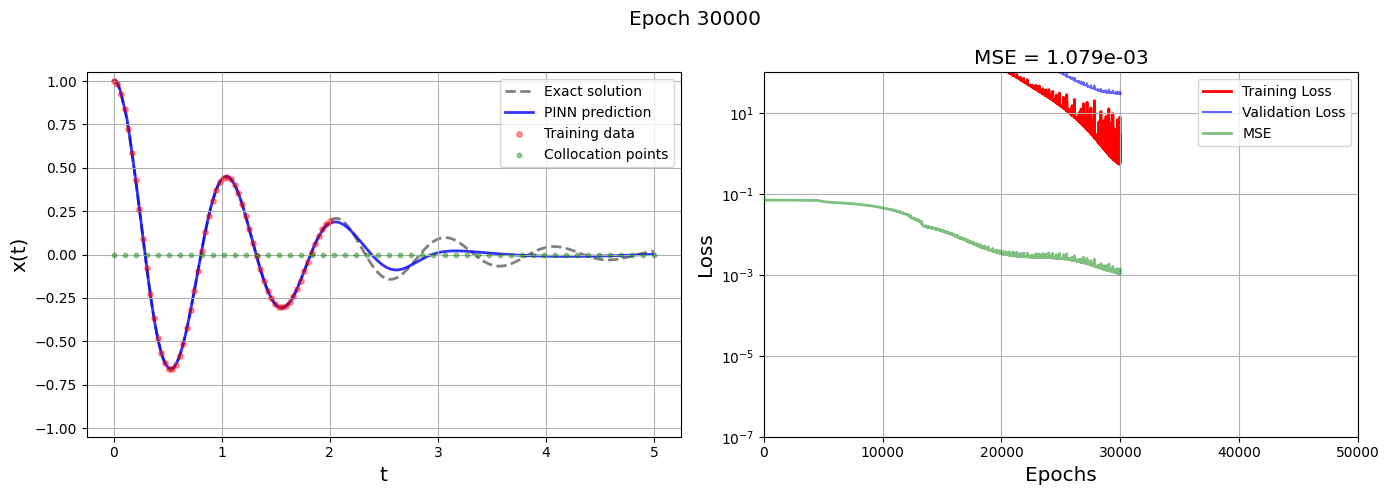

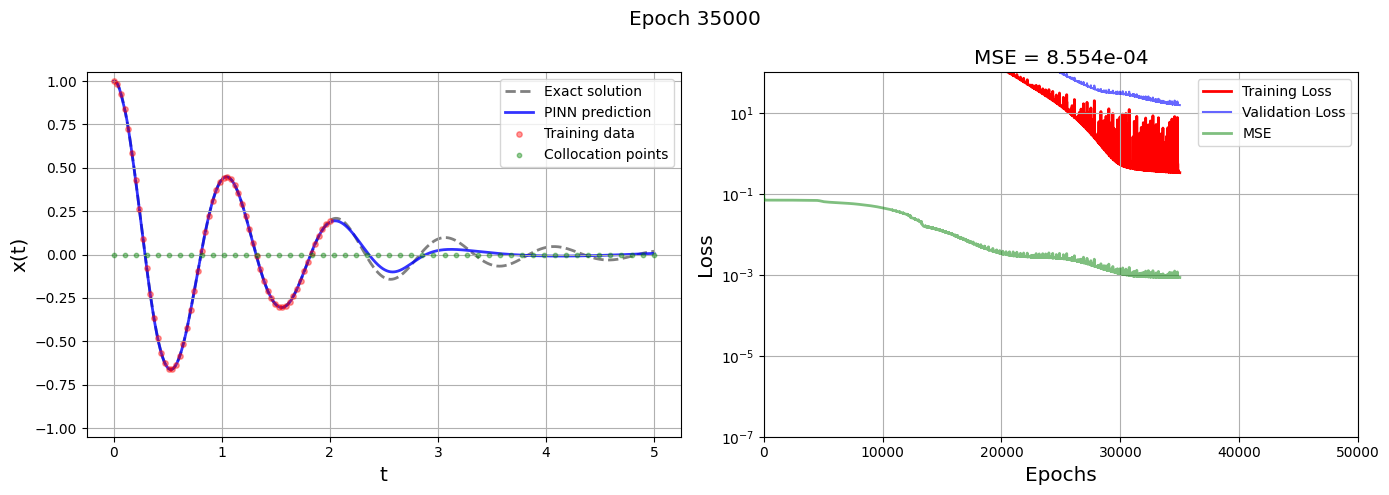

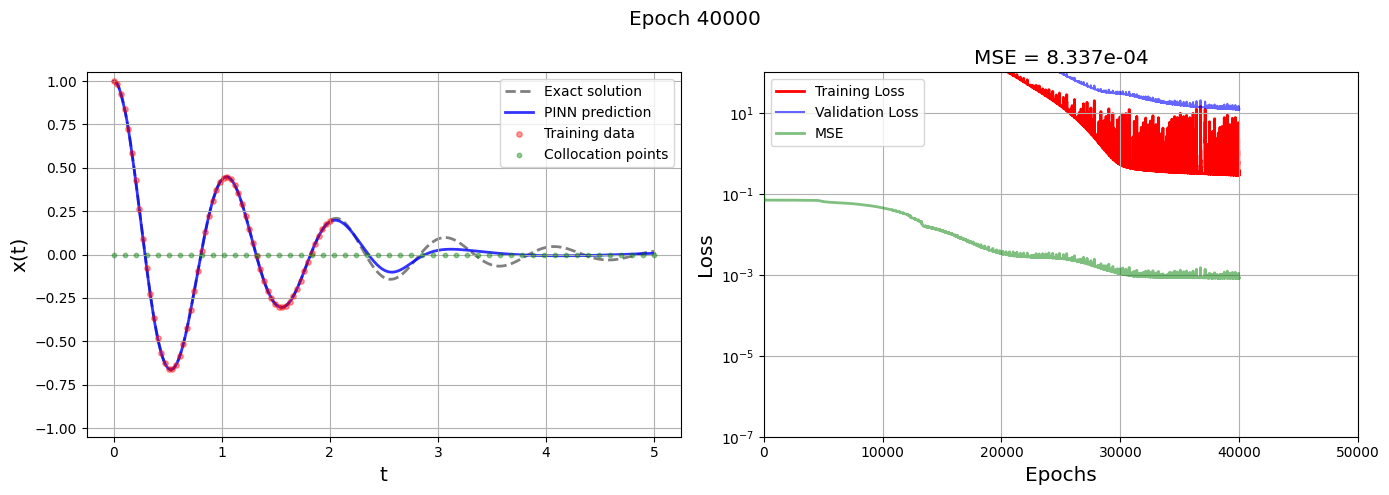

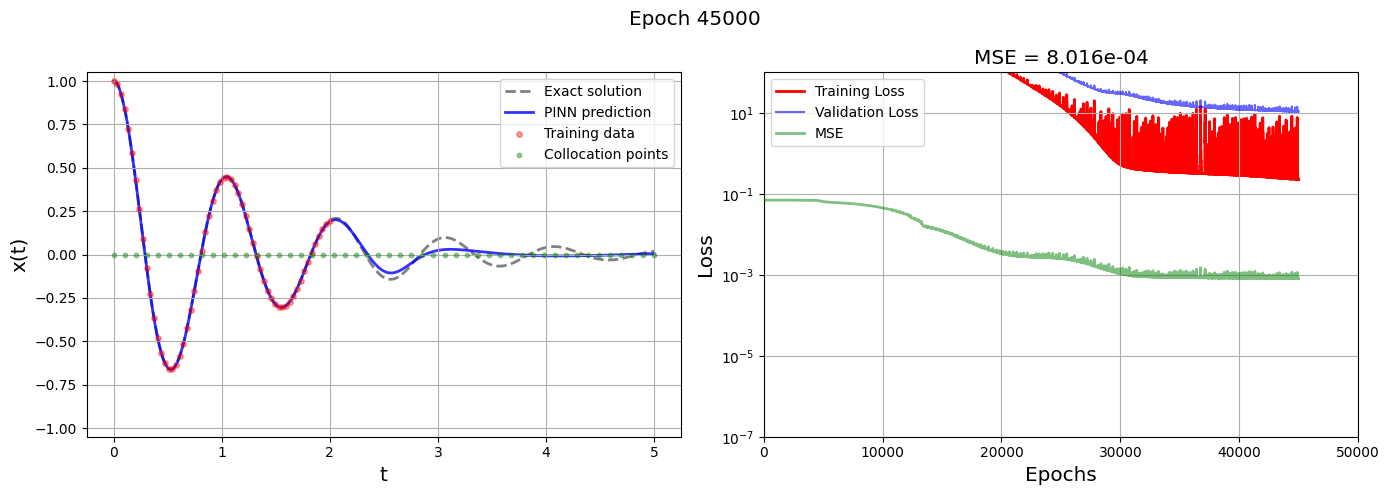

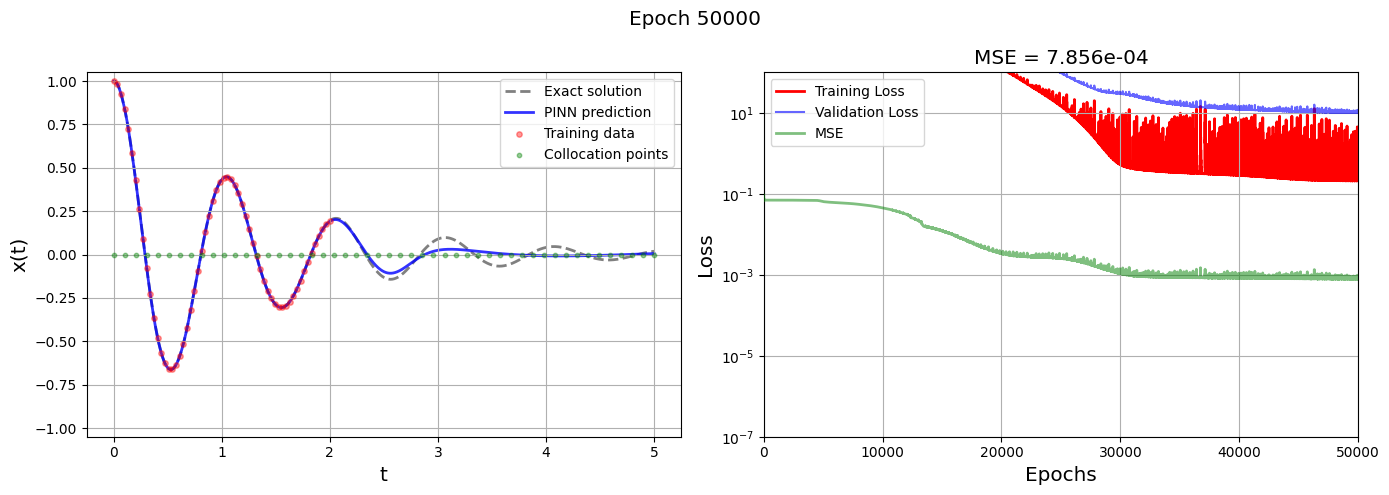

In [252]:
# PINN
PINN = FCN(1, 1, N_nodes, N_layers)

omega = torch.nn.Parameter(2*np.pi*4*torch.ones(1, requires_grad=True))
beta  = torch.nn.Parameter(2*torch.ones(1, requires_grad=True))

# Uses the Adam optimizer
optimizer = torch.optim.Adam(list(PINN.parameters())+[beta]+[omega], lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# Number of training steps
error_history           = []
training_loss_history   = []
validation_loss_history = []

omega_history = []
beta_history  = []

for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data and derivative loss .........................
    u  = PINN(t_training)
    du = torch.autograd.grad(u, t_training, torch.ones_like(u), create_graph=True)[0]
    
    data_loss       = torch.mean((u  - x1_data)**2)
    derivative_loss = torch.mean((du - x2_data)**2)
    
    # Compute the ODE loss .........................
    
    z   = PINN(t_physics)
    dz  = torch.autograd.grad(z, t_physics, torch.ones_like(z), create_graph=True)[0]
    d2z = torch.autograd.grad(dz, t_physics, torch.ones_like(dz), create_graph=True)[0]
    
    training_params = (omega, beta)
    ode = d2z - F(z, dz, t_physics, training_params)
    ode_loss    = torch.mean(ode**2)
    energy_loss = torch.mean((E(z, dz, t_physics) - E0)**2)
    
    # Compute total loss
    loss = w_data*data_loss + w_derivative*derivative_loss + w_ode*ode_loss + w_energy*energy_loss
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    
    # ===
    # Validation
    # ===
    PINN.eval()

    v   = PINN(t_validation)
    dv  = torch.autograd.grad(v, t_validation, torch.ones_like(v), create_graph=True)[0]
    d2v = torch.autograd.grad(dv, t_validation, torch.ones_like(dv), create_graph=True)[0]
    
    data_loss_val       = torch.mean((v - x1_val)**2)
    derivative_loss_val = torch.mean((dv - x2_val)**2)
    ode_loss_val        = torch.mean((d2v - F(x1_val, x2_val, t_validation, training_params))**2)
    energy_loss_val     = torch.mean((E(v, dv, t_validation) - E0)**2)

    loss_val = w_data*data_loss_val + w_derivative*derivative_loss_val + w_ode*ode_loss_val + w_energy*energy_loss_val
    
    # ===
    # Saving training information
    # ===
    p = PINN(t).detach()
    error = torch.mean((p - x1.view(-1,1))**2).item()
    
    error_history.append(error)
    training_loss_history.append(loss.item())
    validation_loss_history.append(loss_val.item())
    
    omega_history.append(omega.item())
    beta_history.append(beta.item())
    
    # ===
    # Plotting
    # ===
    if (i % 1_000) == 0: 
        plot_result()
        if i == (epochs-1):
            plt.show()
        elif (i % 5_000) == 0:
            plt.show()
        else: 
            plt.close("all")

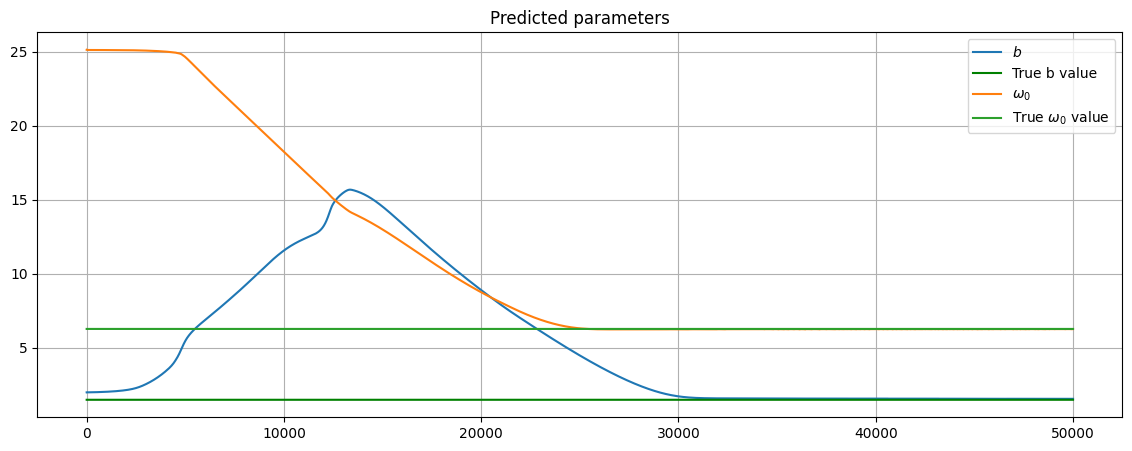

In [253]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(beta_history, label="$b$")
ax.plot(b*np.ones_like(beta_history), label="True b value", color="green")
ax.set_title("Predicted parameters")

ax.plot(omega_history, label="$\omega_0$")
ax.plot(w0*np.ones_like(omega_history), label="True $\omega_0$ value")

ax.grid()
plt.legend()
plt.savefig("plots/dampening_prediction.png")
plt.show()